# Datathon

In [3]:
import pandas as pd

In [4]:
rejected = pd.read_csv("Lending_Club_Rejected_2014_2018.csv")

In [5]:
accepted = pd.read_csv("Lending_Club_Accepted_2014_2018.csv")

/var/folders/bh/b7l9xs7133g2k2ztkrf8jywr0000gn/T/ipykernel_56539/2282768605.py:1: DtypeWarning: Columns (19,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  accepted = pd.read_csv("Lending_Club_Accepted_2014_2018.csv")


In [6]:
print(rejected.keys())
print(accepted.keys())

Index(['Amount_Requested', 'Application_Date', 'Loan_Title', 'Risk_Score',
       'Debt_to_Income_Ratio', 'Zip_Code', 'State', 'Employment_Length',
       'Policy_Code'],
      dtype='object')
Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=151)


In [7]:
print(accepted['emp_length'].unique())

['10+ years' '3 years' '4 years' '6 years' '1 year' '7 years' '8 years'
 '5 years' '2 years' '9 years' '< 1 year' nan]


In [8]:
def trim_accept(accept):
    cols = ['loan_amnt', 'title','dti','zip_code','addr_state','emp_length','policy_code', 'issue_d']
    trimmed_acp = accept[cols]
    return trimmed_acp 

def trim_rej(rej):
    return rej[["Amount_Requested", "Loan_Title", "Debt_to_Income_Ratio", "Zip_Code", "State", "Employment_Length", "Policy_Code", 'Application_Date']]

In [9]:
rejected_dropna = pd.DataFrame(trim_rej(rejected).dropna())
# print(rejected_dropna.shape)

In [10]:
accepted_dropna = pd.DataFrame(trim_accept(accepted).dropna())
# print(accepted_dropna.shape)
accepted_dropna.to_csv("accepted_dropna.csv")

In [11]:
rejected_dropna.to_csv('rejected_dropna.csv')
accepted_dropna.to_csv("accepted_dropna.csv")

In [12]:

def unifyDate(accepted_dropna, rejected_dropna):
    '''Only keep the samples from 2016/4 to 2016/12 and unify the data format to be one integer representing the month'''
    monthNameToInt = {
        "Jan": 1,
        "Feb": 2,
        "Mar": 3,
        "Apr": 4,
        "May": 5,
        "Jun": 6,
        "Jul": 7,
        "Aug": 8,
        "Sep": 9,
        "Oct": 10,
        "Nov": 11,
        "Dec": 12
    }
    
    ## Proccess accepted
    # filter to keep the 2016 year
    accepted_dropna = accepted_dropna[accepted_dropna['issue_d'].str.endswith('2016')]
    accepted_dropna['month'] = accepted_dropna['issue_d'].str[0:3].map(monthNameToInt)
    del accepted_dropna['issue_d']

    ## Process rejected
    rejected_dropna['month'] = rejected_dropna['Application_Date'].str[5:7].astype(int)
    del rejected_dropna['Application_Date']
    
    ## Final
    return (accepted_dropna, rejected_dropna)

accepted_dropna, rejected_dropna = unifyDate(accepted_dropna, rejected_dropna)
print(accepted_dropna)

/var/folders/bh/b7l9xs7133g2k2ztkrf8jywr0000gn/T/ipykernel_56539/4077895458.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accepted_dropna['month'] = accepted_dropna['issue_d'].str[0:3].map(monthNameToInt)


         loan_amnt                    title    dti zip_code addr_state  \
651660     10000.0       Debt consolidation  13.05    447xx         OH   
651661     12000.0       Debt consolidation  22.86    774xx         TX   
651662     20000.0  Credit card refinancing  17.05    960xx         CA   
651663      4900.0         Home improvement   6.07    770xx         TX   
651664     21000.0       Debt consolidation   9.87    913xx         CA   
...            ...                      ...    ...      ...        ...   
2029945    16000.0         Medical expenses  12.25    284xx         NC   
2029946    24000.0  Credit card refinancing  10.98    967xx         HI   
2029947    24000.0         Home improvement  19.61    356xx         AL   
2029948    24000.0       Debt consolidation  34.94    840xx         UT   
2029950    24000.0       Debt consolidation  18.30    334xx         FL   

        emp_length  policy_code  month  
651660     3 years          1.0      6  
651661     7 years          1

In [13]:
accepted_dropna.columns = ['Amount_Requested', 'Loan_Title', 'Debt_to_Income_Ratio', 'Zip_Code', 'State', 'Employment_Length', 'Policy_Code', 'month']

In [14]:
accepted_dropna["Status"] = 1
rejected_dropna["Status"] = 0
rejected_dropna["Debt_to_Income_Ratio"] = rejected_dropna["Debt_to_Income_Ratio"].str.rstrip("%").astype("float") 
frames = [accepted_dropna,rejected_dropna]
merged = pd.concat(frames)

In [15]:
merged.Employment_Length = merged.Employment_Length.str[:2]
merged.loc[ merged["Employment_Length"] == "< ", "Employment_Length"] = 0.1
merged["Employment_Length"] = merged["Employment_Length"].astype("float") 

In [16]:
merged_copy = merged.copy()

In [17]:
print(merged.keys())

Index(['Amount_Requested', 'Loan_Title', 'Debt_to_Income_Ratio', 'Zip_Code',
       'State', 'Employment_Length', 'Policy_Code', 'month', 'Status'],
      dtype='object')


In [18]:
income_by_state = pd.read_csv("state_average_income_2016.csv")
states = income_by_state[income_by_state.columns[0]].to_numpy()
states = np.array(states)
income_by_state = income_by_state[0:51]
income_by_state = income_by_state[['state', 'income']]

incomes = income_by_state[income_by_state.columns[1]].to_numpy()
income_by_state_dict = dict(zip(states, incomes))
def modify_state(state):
    income_by_state_dict[state]

In [19]:
merged_copy2 = merged_copy.copy()

In [20]:
merged_copy2["State"] = merged_copy2["State"].map(income_by_state_dict).str.replace(',', "").astype(int)

In [21]:
merged = merged_copy2
print(merged)

          Amount_Requested               Loan_Title  Debt_to_Income_Ratio  \
651660             10000.0       Debt consolidation                 13.05   
651661             12000.0       Debt consolidation                 22.86   
651662             20000.0  Credit card refinancing                 17.05   
651663              4900.0         Home improvement                  6.07   
651664             21000.0       Debt consolidation                  9.87   
...                    ...                      ...                   ...   
26132303           10000.0       Debt consolidation                 41.26   
26132304           10000.0                   moving                  1.48   
26132305            1200.0                    Other                 10.26   
26132306           25000.0       debt_consolidation                 17.71   
26132307           15000.0                 Business                 10.58   

         Zip_Code  State  Employment_Length  Policy_Code  month  Status  
6

In [22]:
merged = merged.sample(frac=1).reset_index(drop=True)
# display the dataFrame without line breaks
pd.set_option('display.expand_frame_repr', False)

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], dtype='object')


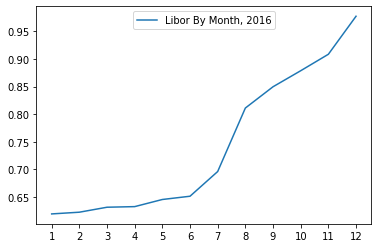

In [23]:
from matplotlib import pyplot as plt
libor = pd.read_csv('libor.csv')
print(libor.keys())
month = list(libor.columns)
index = list(libor.iloc[0])

plt.plot(month,index, label="Libor By Month, 2016")
leg = plt.legend(loc='upper center')
plt.show()

In [24]:
monthly_para = []
monthly_accur = {}

### Import scikit learn libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

for m in range (4,13):
    #select the corresponding month in libor and merge
    month_merge = merged.loc[merged['month'] == m]
    numerical_features = ["Amount_Requested", "Debt_to_Income_Ratio", "Employment_Length", "Policy_Code", "State"]
    X = month_merge[numerical_features]
    y = month_merge["Status"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Build Classifier
    logreg = LogisticRegression(max_iter=1000000)
    LogRegClassifier = logreg.fit(X_train, y_train)

    # Visualize weights
    coef = LogRegClassifier.coef_[0]
    monthly_para.append(list(coef))

    # Test Accuracy
    y_hat = LogRegClassifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_hat, y_hat)
    monthly_accur[m] = accuracy

print(monthly_para)
print(monthly_accur)

# find the parameter that has the highest correlation with
import numpy as np

[[-2.614157641638978e-06, -0.01648258652084902, 0.46671122493428013, 0.08992922345379885, -7.89818662856636e-05], [-2.847242010036561e-07, -0.01652592837875784, 0.4733565068757096, 0.09154618509069806, -8.474690811894779e-05], [7.426120777168704e-06, -0.019978197521955798, 0.44784963260316435, 0.09152302607309347, -8.314862255050298e-05], [7.35387417363786e-07, -0.02097932884700583, 0.4554751870158912, 0.09128095713317147, -8.27156684134999e-05], [6.702281021674935e-07, -0.020957772842833695, 0.4646212975559942, 0.09115619282215752, -8.226701941623822e-05], [-9.33273312680362e-07, -0.023537619215206668, 0.4661059707760068, 0.089967811702189, -8.257583341205381e-05], [-2.693001334841778e-06, -0.021719655309100916, 0.4779220578743743, 0.08777725224970444, -8.075798947262817e-05], [4.60145674216109e-07, -0.021250927262183406, 0.4783329506419904, 0.08809254779468122, -8.026637630974963e-05], [3.7619765301972104e-06, -0.01893031360130485, 0.47653456863901006, 0.09212625276398702, -8.1288208

In [25]:
monthly_params = np.array(monthly_para)
#print(monthly_params)
print('------')

index = list(libor.iloc[0])
index = index[3:]
index = np.array(index)

all_params_by_month = []
for col in range(5):
    # the weights of one feature from all months
    param_by_month = np.array(monthly_params[:, col])
    R = np.corrcoef(param_by_month, index)
    print(R[0, 1])

------
-0.03756742688661683
-0.5321675892412779
0.6318750410107173
-0.3234503128386972
0.31642684966864976


## Integrate analysis with LIBOR data

In [26]:
libor = pd.read_csv("LIBOR14to18.csv")

In [27]:
def modify_date(input_date):
    input_year = input_date[-4:]
    input_month = input_date[0:3]
    month_dict = {"Jan": "01", "Feb": "02", "Mar": "03", "Apr": "04", "May": "05", 
    "Jun": "06", "Jul": "07", "Aug": "08", "Sep": "09", "Oct": "10", "Nov": "11", "Dec": "12"}
    month = month_dict[input_month]
    return input_year + month

trimmed = accepted[["int_rate", "issue_d"]]
trimmed.issue_d = trimmed["issue_d"].apply(modify_date)
trimmed.sort_values(by=['issue_d'])
int_rate_monthly = trimmed.groupby(by=['issue_d']).mean()
print(int_rate_monthly)

/var/folders/bh/b7l9xs7133g2k2ztkrf8jywr0000gn/T/ipykernel_56539/615992061.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed.issue_d = trimmed["issue_d"].apply(modify_date)


          int_rate
issue_d           
201401   14.209685
201402   14.314247
201403   14.453305
201404   14.395606
201405   13.959840
201406   13.850323
201407   13.919243
201408   13.892222
201409   13.392782
201410   13.298481
201411   13.093683
201412   12.705817
201501   13.053058
201502   12.726625
201503   12.772612
201504   12.789420
201505   12.749449
201506   12.761709
201507   12.705187
201508   12.590873
201509   12.657968
201510   12.281337
201511   12.169902
201512   12.279697
201601   12.290103
201602   12.547103
201603   12.526671
201604   12.429358
201605   12.503870
201606   12.509503
201607   13.685528
201608   13.646460
201609   13.866895
201610   13.571570
201611   13.549768
201612   13.829173
201701   13.564876
201702   13.389176
201703   13.183129
201704   13.299691
201705   13.292932
201706   13.263503
201707   13.430335
201708   13.235223
201709   13.760751
201710   13.211537
201711   12.776701
201712   12.651806
201801   12.385711
201802   12.460285
201803   12.

In [28]:
import numpy as np
x = libor[libor.columns[1]].to_numpy()
print(x)
# x = libor[["int_rate"]].to_numpy()
y = int_rate_monthly[int_rate_monthly.columns[0]].to_numpy()
print(y)
corr = np.corrcoef(x[48:60], y[48:60])
print(corr)

[0.2386 0.2352 0.2341 0.2273 0.2261 0.2309 0.2342 0.2348 0.234  0.2314
 0.2329 0.2457 0.2544 0.2584 0.2683 0.2758 0.2798 0.2827 0.2907 0.3212
 0.3311 0.3214 0.371  0.5393 0.6196 0.6227 0.6317 0.6328 0.6457 0.6516
 0.6963 0.8112 0.8497 0.8787 0.9085 0.9773 1.0244 1.0446 1.1347 1.159
 1.186  1.2624 1.3075 1.3143 1.3233 1.3608 1.4342 1.6098 1.7322 1.8747
 2.1796 2.3476 2.3363 2.3303 2.3391 2.3233 2.3494 2.4606 2.6492 2.7902]
[14.20968518 14.31424717 14.45330467 14.39560589 13.95983978 13.85032307
 13.9192435  13.89222228 13.39278239 13.29848078 13.09368285 12.70581741
 13.05305808 12.72662474 12.7726122  12.78941993 12.74944881 12.76170862
 12.70518711 12.59087332 12.6579676  12.28133742 12.16990248 12.27969691
 12.29010289 12.54710314 12.52667134 12.42935826 12.50387001 12.50950332
 13.68552801 13.64646003 13.86689525 13.57156994 13.54976844 13.82917282
 13.56487577 13.38917624 13.18312929 13.29969107 13.29293225 13.26350303
 13.4303349  13.23522342 13.76075064 13.21153705 12.77670123 12

### Train SP 500

In [29]:
import numpy as np
from bs4 import BeautifulSoup
import requests
#the website URL
url_link = "https://www.multpl.com/s-p-500-historical-prices/table/by-month"
result = requests.get(url_link).text
doc = BeautifulSoup(result, "html.parser")

date = doc.select(".left")
price = doc.select(".right")

historical_date = []
historical_price = []


for time in range (69,81):
    historical_date.append(str(date[time])[17:28])
    historical_price.append(float(str(price[time])[18:26].replace(",",'')))

historical_date.reverse()
historical_price.reverse()
monthly_params = np.array(monthly_para)
#print(monthly_params)
print('------')

index = historical_price
index = index[3:]
index = np.array(index)

all_params_by_month = []
s = []
for col in range(5):
    # the weights of one feature from all months
    param_by_month = np.array(monthly_params[:, col])
    R = np.corrcoef(param_by_month, index)
    s.append(R[0, 1])

print(s)

------
[0.13084119373312983, -0.4724583860941195, 0.36624630745575176, 0.033600294119351046, 0.21916882070454655]


## Logistic Regression Sample code

In [30]:
### Extract all the numerical features(columns)
numerical_features = ["Amount_Requested", "Debt_to_Income_Ratio", "Employment_Length", "Policy_Code"]

X = merged[numerical_features]
y = merged["Status"]

print(X.shape)
print(y.shape)

(25584076, 4)
(25584076,)


In [31]:
### Import scikit learn libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

In [32]:
### Data exploration
print(merged["Status"].value_counts())
print("y=1 samples takes the porportion of", 1871838 / (25197853 + 1871838))

0    25197853
1      386223
Name: Status, dtype: int64
y=1 samples takes the porportion of 0.06914884990744814


In [ ]:
def LinearRegressionTrainAndTest(X, y):
    '''Prints the weights and the accuracy of the model'''
    # Split train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Build Classifier
    logreg = LogisticRegression(max_iter=1000000)
    LogRegClassifier = logreg.fit(X_train, y_train)

    # Visualize weights
    coef = LogRegClassifier.coef_[0]
    print(coef)

    # Test Accuracy
    y_hat = LogRegClassifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_hat, y_hat)
    print(accuracy)

#### Result
Data | State | Weights | Accuracy
| --- | --- | --- | --- |
First 1000 samples | converged | [-3.86427605e-06 -7.79187122e-03  2.72544483e-01  4.93654007e+00] |
First 100000 samples | converged | [-1.82404211e-05 -1.88134360e-02  2.03956568e-01  7.15292616e+00] | 
First 1000000 samples | converged | [-2.71159981e-05 -1.78985938e-02  2.21481719e-01  7.37541925e+00] | 
Full data set | converged | [-2.21539709e-05 -1.73101075e-02  2.18396270e-01  7.38836630e+00] | 0.9969306387906377
 